In [1]:
%matplotlib inline

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import sys
sys.path.append('../../helper_libraries')

In [2]:
from utilities import read_UCINET_matrix, get_all_node_metrics, get_all_graph_metrics
from utilities import get_nodes_as_dataframe
from utilities import plot_network, run_all_simulations

In [3]:
sheet_name="FRIENDSHIP"
G = read_UCINET_matrix(
    "../../data/krack-high-tec.xlsx",
    sheet_name=sheet_name,
    attribute_file="../../data/high-tec-attributes.xlsx",
    directed=False
)

In [4]:
df_node_metrics = get_all_node_metrics(G)
df = get_nodes_as_dataframe(G)
df

,AGE,TENURE,LEVEL,DEPT,degree,betweenness,closeness,eigenvector,clustering
1,33,9.333,3,4,0.45,0.020451,0.645161,0.255595,0.611111
2,42,19.583,2,4,0.50,0.049925,0.666667,0.262091,0.466667
3,40,12.750,3,2,0.30,0.006366,0.588235,0.184081,0.666667
4,33,7.500,3,4,0.35,0.007820,0.606061,0.201748,0.714286
5,32,3.333,3,2,0.50,0.063622,0.666667,0.259646,0.444444
6,59,28.000,3,1,0.35,0.022857,0.588235,0.177678,0.428571
7,55,30.000,1,0,0.15,0.001754,0.512821,0.084802,0.666667
8,34,11.333,3,1,0.25,0.003383,0.571429,0.156935,0.700000
9,62,5.417,3,2,0.30,0.006980,0.588235,0.183069,0.666667
10,37,9.250,3,3,0.40,0.032682,0.625000,0.192981,0.285714


In [5]:
len(G.edges)

79

In [6]:
21*20/2

210.0

## Link prediction

In [7]:
def node_similarity(u, v, df):
    features = {}
    features["AGE"] = np.abs(df.loc[u, "AGE"] - df.loc[v, "AGE"])
    features["TENURE"] = np.abs(df.loc[u, "TENURE"] - df.loc[v, "TENURE"])
    features["LEVEL"] = df.loc[u, "LEVEL"] == df.loc[v, "LEVEL"]
    features["DEPT"] = df.loc[u, "DEPT"] == df.loc[v, "DEPT"]
    return features
    

In [8]:
df_node_metrics.loc[1]

degree         0.450000
betweenness    0.020451
closeness      0.645161
eigenvector    0.255595
clustering     0.611111
Name: 1, dtype: float64

In [9]:
node_similarity(1, 2, df)

{'AGE': 9, 'DEPT': True, 'LEVEL': False, 'TENURE': 10.25000000000003}

In [10]:
data = []
for u in G.nodes:
    for v in G.nodes:
        if u!=v:
            features = node_similarity(u,v,df)
            features["u"] = u
            features["v"] = v
            features["is_edge"] = (u,v) in G.edges
            data.append(features)

In [11]:
df_features = pd.DataFrame(data)
df_features.head()

,AGE,DEPT,LEVEL,TENURE,is_edge,u,v
0,9,True,False,10.250,True,1,2
1,7,False,True,3.417,False,1,3
2,0,True,True,1.833,True,1,4
3,1,False,True,6.000,False,1,5
4,26,False,True,18.667,False,1,6


In [12]:
df_features.is_edge.value_counts()

False    262
True     158
Name: is_edge, dtype: int64

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [14]:
X = df_features[["AGE", "TENURE", "LEVEL", "DEPT"]]
Y = df_features.is_edge

In [15]:
X.head()

,AGE,TENURE,LEVEL,DEPT
0,9,10.250,False,True
1,7,3.417,True,False
2,0,1.833,True,True
3,1,6.000,True,False
4,26,18.667,True,False


In [16]:
Y.head()

0     True
1    False
2     True
3    False
4    False
Name: is_edge, dtype: bool

In [17]:
model = LogisticRegression()
model.fit(X, Y)
model.classes_

array([False,  True])

In [18]:
pd.DataFrame(model.coef_, columns=X.columns)

,AGE,TENURE,LEVEL,DEPT
0,-0.056438,0.037135,0.847679,1.088476


In [19]:
from sklearn.metrics import accuracy_score, classification_report, auc

In [20]:
Y_pred = model.predict(X)
print(classification_report(Y_pred, Y))
print("Accuracy: {:.3f}".format(accuracy_score(Y_pred, Y)))

             precision    recall  f1-score   support

      False       0.88      0.66      0.75       348
       True       0.25      0.56      0.35        72

avg / total       0.77      0.64      0.68       420

Accuracy: 0.643


In [21]:
model = RandomForestClassifier()
model.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
pd.DataFrame([model.feature_importances_], columns=X.columns)

,AGE,TENURE,LEVEL,DEPT
0,0.325363,0.528264,0.085996,0.060376


In [23]:
Y_pred = model.predict(X)
print(classification_report(Y_pred, Y))
print("Accuracy: {:.3f}".format(accuracy_score(Y_pred, Y)))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00       262
       True       1.00      1.00      1.00       158

avg / total       1.00      1.00      1.00       420

Accuracy: 1.000


In [24]:
model.classes_

array([False,  True])

## Evaluation using cross validation

In [25]:
from sklearn.cross_validation import ShuffleSplit

F:\ProgramData\Anaconda3\envs\na_spring_2018\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
def train_model(X, Y, model_class, n_iters=3):
    rs = ShuffleSplit(X.shape[0], n_iter=n_iters)
    models = []
    for train_idx, test_idx in rs:
        model = model_class()
        model.fit(X.iloc[train_idx], Y.iloc[train_idx])
        Y_pred = model.predict(X.iloc[test_idx])
        #print(classification_report(Y_pred, Y.iloc[test_idx]))
        print("Accuracy: {:.3f}, AUC: {:.3f}".format(
            accuracy_score(Y_pred, Y.iloc[test_idx]),
            auc(Y_pred, Y.iloc[test_idx])
        ))
        models.append(model)
    return models

In [27]:
models = train_model(X, Y, LogisticRegression, n_iters=3)
pd.DataFrame([
    model.coef_[0]
    for model in models
],
    columns=X.columns)

Accuracy: 0.738, AUC: 4.500
Accuracy: 0.643, AUC: 3.500
Accuracy: 0.643, AUC: 3.000


,AGE,TENURE,LEVEL,DEPT
0,-0.051613,0.030085,0.780780,0.986626
1,-0.061188,0.040804,0.944892,0.984603
2,-0.053150,0.029898,0.824855,1.090007


In [28]:
models = train_model(X, Y, RandomForestClassifier, n_iters=3)
pd.DataFrame([
    model.feature_importances_
    for model in models
],
    columns=X.columns)

Accuracy: 1.000, AUC: 6.000
Accuracy: 0.976, AUC: 10.000
Accuracy: 0.976, AUC: 9.000


,AGE,TENURE,LEVEL,DEPT
0,0.340708,0.513138,0.098309,0.047845
1,0.368689,0.498357,0.052556,0.080398
2,0.312729,0.518060,0.084520,0.084691


In [29]:
df_features.assign(prediction=lambda x: models[0].predict(X))

,AGE,DEPT,LEVEL,TENURE,is_edge,u,v,prediction
0,9,True,False,10.250,True,1,2,True
1,7,False,True,3.417,False,1,3,False
2,0,True,True,1.833,True,1,4,True
3,1,False,True,6.000,False,1,5,False
4,26,False,True,18.667,False,1,6,False
5,22,False,False,20.667,False,1,7,False
6,1,False,True,2.000,True,1,8,True
7,29,False,True,3.916,False,1,9,False
8,4,False,True,0.083,False,1,10,False
9,13,False,True,17.667,True,1,11,True


## Community detection

In [30]:
nx.algorithms.community.girvan_newman(G)

<generator object girvan_newman at 0x00000158B1EF5AF0>

In [31]:
for nodes in nx.algorithms.community.girvan_newman(G):
    print(nodes)

({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21}, {13})
({1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21}, {7}, {13})
({1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21}, {7}, {13}, {18})
({1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20}, {7}, {13}, {18}, {21})
({1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 15, 16, 17, 19, 20}, {7}, {13}, {14}, {18}, {21})
({1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 16, 17, 19, 20}, {6}, {7}, {13}, {14}, {18}, {21})
({1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 17, 19, 20}, {6}, {7}, {13}, {14}, {16}, {18}, {21})
({1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 15, 17, 19}, {6}, {7}, {13}, {14}, {16}, {18}, {20}, {21})
({1, 2, 3, 4, 5, 8, 10, 11, 12, 15, 17, 19}, {6}, {7}, {9}, {13}, {14}, {16}, {18}, {20}, {21})
({1, 2, 4, 5, 8, 10, 11, 12, 15, 17, 19}, {3}, {6}, {7}, {9}, {13}, {14}, {16}, {18}, {20}, {21})
({1, 2, 4, 5, 8, 11, 12, 15, 17, 19}, {3}, {6}, {7}, {9}, {10}, {13}, {14}, {16}, {18}, {20}, {21})
({1, 2, 4,

In [32]:
communities_generator = nx.algorithms.community.girvan_newman(G)
top_level_communities = next(communities_generator)

In [33]:
top_level_communities

({1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21}, {13})

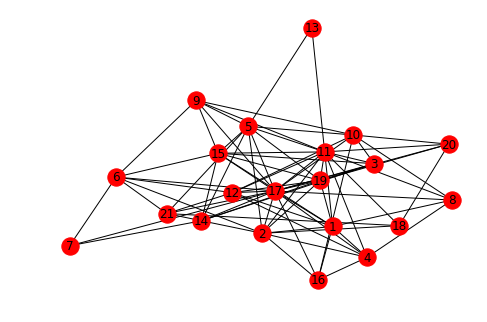

In [34]:
nx.draw(G, with_labels=True)